In [1]:
%load_ext autoreload
%autoreload 2

import logging
from pathlib import Path

import awkward as ak
import numpy as np
import vector
from omegaconf import OmegaConf

import gabbro.plotting.utils as plot_utils
from gabbro.metrics.jet_substructure import JetSubstructure
from gabbro.plotting.feature_plotting import plot_features
from gabbro.utils.arrays import ak_select_and_preprocess

vector.register_awkward()

# hacky way to setup logging in jupyter
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)
logger.info("Setup complete")


def get_p4s_from_part_features(part_features):
    """Small helper function to get the 4-momentum from part_features."""
    return ak.zip(
        {
            "pt": part_features.part_pt,
            "eta": part_features.part_etarel,
            "phi": part_features.part_phirel,
            "mass": ak.zeros_like(part_features.part_pt),  # massless particles
        },
        with_name="Momentum4D",
    )

INFO:numexpr.utils:Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:root:Setup complete


# Jet generation with a trained OmniJet model

This notebook provides a short example on how to load a trained OmniJet model
with the next-token-prediction head and generate jets with it.

For an example on how to reconstruct the generated jets back to physical space, 
have a look at [the notebook `examples/notebooks/example_tokenize_and_reconstruct_jets.ipynb`](https://github.com/uhh-pd-ml/omnijet_alpha/blob/main/examples/notebooks/example_tokenize_and_reconstruct_jets.ipynb)


In [2]:
from gabbro.models.backbone import BackboneNextTokenPredictionLightning

# this checkpoint is the checkpoint from a backbone training with the nex-token-prediction head
# make sure you have downloaded the checkpoint in advance
# if not, run the script `checkpoints/download_checkpoints.sh`
ckpt_path = "../../checkpoints/./generative_8192_tokens/OmniJet_generative_model_UnintentionalPinscher_59.ckpt"

gen_model = BackboneNextTokenPredictionLightning.load_from_checkpoint(ckpt_path)
gen_model.eval()

Backbone weights path: None


BackboneNextTokenPredictionLightning(
  (module): BackboneModel(
    (embedding_table): Embedding(8194, 256)
    (GPT_blocks): Sequential(
      (0): GPT_DecoderBlock(
        (mha_block): MultiHeadAttention(
          (key): Linear(in_features=256, out_features=256, bias=False)
          (query): Linear(in_features=256, out_features=256, bias=False)
          (value): Linear(in_features=256, out_features=256, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff_block): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=256, out_features=1024, bias=True)
            (1): ReLU()
            (2): Linear(in_features=1024, out_features=256, bias=True)
          )
        )
        (layernorm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layernorm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (1): GPT_DecoderBlock(
 

### Generating jets

In [3]:
# save_path = "/beegfs/desy/user/birkjosc/testing/omnijet/generated_jets.parquet"
generated_jets = gen_model.generate_n_jets_batched(
    n_jets=2_000,
    batch_size=512,
    # saveas=save_path,  # use this option if you want to save the awkward array as a parquet file
)

Generating 2000 jets in 4 batches of size 512


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:18<00:00,  4.66s/it]


In [4]:
generated_jets

<Array [[0, 6483, 6913, ..., 3748, 4546, 4036], ...] type='2000 * var * int64'>

## Reconstruct the generated jets back to physical space

In [5]:
# --- Load the tokenizer model from checkpoint, and also get the feature_dict from the config ---

from gabbro.models.vqvae import VQVAELightning

# this checkpoint is the checkpoint from a tokenization training
ckpt_path = "../../checkpoints/vqvae_8192_tokens/model_ckpt.ckpt"
vqvae_model = VQVAELightning.load_from_checkpoint(ckpt_path)
vqvae_model.eval()

cfg = OmegaConf.load(Path(ckpt_path).parent / "config.yaml")
pp_dict = OmegaConf.to_container(cfg.data.dataset_kwargs_common.feature_dict)
print("\npp_dict:")
for item in pp_dict:
    print(item, pp_dict[item])

# get the cuts from the pp_dict (since this leads to particles being removed during
# preprocessing/tokenization), thus we also have to remove them from the original jets
# when we compare the tokenized+reconstructed particles to the original ones)
pp_dict_cuts = {
    feat_name: {
        criterion: pp_dict[feat_name].get(criterion)
        for criterion in ["larger_than", "smaller_than"]
    }
    for feat_name in pp_dict
}

print("\npp_dict_cuts:")
for item in pp_dict_cuts:
    print(item, pp_dict_cuts[item])

print("\nModel:")
print(vqvae_model)


pp_dict:
part_pt {'multiply_by': 1, 'subtract_by': 1.8, 'func': 'np.log', 'inv_func': 'np.exp'}
part_etarel {'multiply_by': 3, 'larger_than': -0.8, 'smaller_than': 0.8}
part_phirel {'multiply_by': 3, 'larger_than': -0.8, 'smaller_than': 0.8}

pp_dict_cuts:
part_pt {'larger_than': None, 'smaller_than': None}
part_etarel {'larger_than': -0.8, 'smaller_than': 0.8}
part_phirel {'larger_than': -0.8, 'smaller_than': 0.8}

Model:
VQVAELightning(
  (model): VQVAENormFormer(
    (input_projection): Linear(in_features=3, out_features=128, bias=True)
    (encoder_normformer): NormformerStack(
      (blocks): ModuleList(
        (0-3): 4 x NormformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (0): La

In [6]:
# reconstruct the generated tokens to physical features

# note that if you want to reconstruct tokens from the generative model, you'll have
# to remove the start token from the tokenized array, and subtract 1 from the tokens
# (since we chose the convention to use 0 as the start token, so the tokens from the
# generative model are shifted by 1 compared to the ones from the VQ-VAE)
part_features_generated = vqvae_model.reconstruct_ak_tokens(
    tokens_ak=generated_jets[:, 1:] - 1,
    pp_dict=pp_dict,
    batch_size=512,
    pad_length=128,
)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 50.28it/s]


In [7]:
from gabbro.data.loading import read_jetclass_file

n_load = 100_000

# --- Load JetClass data ---

# change this to the path where you have the JetClass files stored
jetclass_file_path_qcd = (
    "/beegfs/desy/user/birkjosc/datasets/jetclass/JetClass/test_20M/ZJetsToNuNu_100.root"
)
jetclass_file_path_top = (
    "/beegfs/desy/user/birkjosc/datasets/jetclass/JetClass/test_20M/TTBar_100.root"
)

load_kwargs = dict(
    particle_features=["part_pt", "part_etarel", "part_phirel"],
    jet_features=None,
    labels=None,
    n_load=n_load,
)
part_features_ak_qcd, _, _ = read_jetclass_file(filepath=jetclass_file_path_qcd, **load_kwargs)
part_features_ak_qcd = ak_select_and_preprocess(part_features_ak_qcd, pp_dict_cuts)[:, :128]
part_features_ak_top, _, _ = read_jetclass_file(filepath=jetclass_file_path_top, **load_kwargs)
part_features_ak_top = ak_select_and_preprocess(part_features_ak_top, pp_dict_cuts)[:, :128]

# concatenate top and qcd jets from JetClass
part_features_ak = ak.concatenate([part_features_ak_qcd, part_features_ak_top], axis=0)

# tokenization and reconstruction
part_features_ak_tokenized = vqvae_model.tokenize_ak_array(
    ak_arr=part_features_ak,
    pp_dict=pp_dict,
    batch_size=512,
    pad_length=128,
)
part_features_ak_reco = vqvae_model.reconstruct_ak_tokens(
    tokens_ak=part_features_ak_tokenized,
    pp_dict=pp_dict,
    batch_size=512,
    pad_length=128,
)

# plot inclusive jet-level distributions
p4s_jetclass = get_p4s_from_part_features(part_features_ak_reco)
p4s_jets_jetclass = ak.sum(p4s_jetclass, axis=1)

# calculate the substructure
jet_substructure_jetclass = JetSubstructure(p4s_jetclass[ak.num(p4s_jetclass) > 3])

100%|██████████| 391/391 [00:08<00:00, 47.01it/s]


Calculating substructure for 199976 jets
Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and E scheme recombination


#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Calculating N-subjettiness
Calculating D2


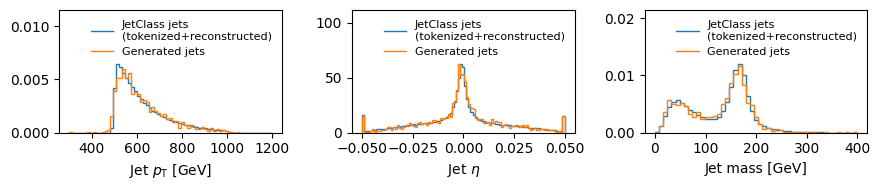

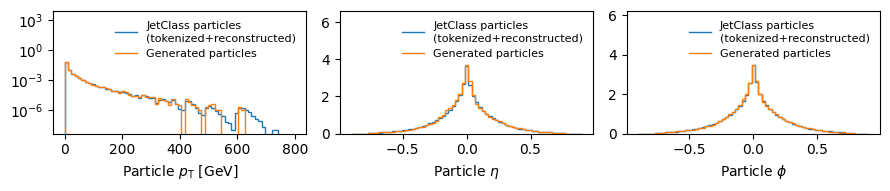

In [8]:
p4s_generated = get_p4s_from_part_features(part_features_generated)
p4s_jets_generated = ak.sum(p4s_generated, axis=1)

fig, axarr = plot_features(
    ak_array_dict={
        "JetClass jets\n(tokenized+reconstructed)": p4s_jets_jetclass,
        "Generated jets": p4s_jets_generated,
    },
    names={
        "pt": plot_utils.DEFAULT_LABELS["jet_pt"],
        "eta": plot_utils.DEFAULT_LABELS["jet_eta"],
        "mass": plot_utils.DEFAULT_LABELS["jet_mass"],
    },
    flatten=False,
    decorate_ax_kwargs={"yscale": 1.7},
    bins_dict={
        "pt": np.linspace(300, 1200, 70),
        "eta": np.linspace(-0.05, 0.05, 100),
        "mass": np.linspace(0, 400, 50),
    },
    # ax_size=(4.2, 3),
    legend_kwargs={"fontsize": 8},
)

# particle-level distributions
fig, axarr = plot_features(
    ak_array_dict={
        "JetClass particles\n(tokenized+reconstructed)": p4s_jetclass,
        "Generated particles": get_p4s_from_part_features(part_features_generated),
    },
    names={
        "pt": plot_utils.DEFAULT_LABELS["part_pt"],
        "eta": plot_utils.DEFAULT_LABELS["part_eta"],
        "phi": plot_utils.DEFAULT_LABELS["part_phi"],
    },
    flatten=True,
    decorate_ax_kwargs={"yscale": 1.7},
    bins_dict={
        "pt": np.linspace(0, 800, 70),
        "eta": np.linspace(-0.9, 0.9, 70),
        "phi": np.linspace(-0.9, 0.9, 70),
    },
    # ax_size=(4.2, 3),
    logscale_features=["pt"],
    legend_kwargs={"fontsize": 8},
)

In [9]:
# calculate the substructure
from gabbro.metrics.jet_substructure import JetSubstructure

jet_substructure_generated = JetSubstructure(p4s_generated[ak.num(p4s_generated) > 3])

Calculating substructure for 1999 jets
Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and E scheme recombination


Calculating N-subjettiness
Calculating D2


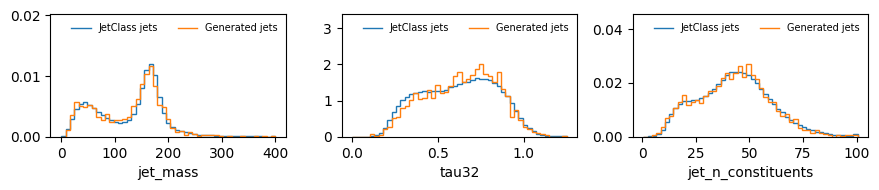

In [10]:
# plot the substructure
fig, axarr = plot_features(
    ak_array_dict={
        "JetClass jets": jet_substructure_jetclass.get_substructure_as_ak_array(),
        "Generated jets": jet_substructure_generated.get_substructure_as_ak_array(),
    },
    names=["jet_mass", "tau32", "jet_n_constituents"],
    flatten=False,
    # ax_size=(3.5, 3),
    legend_kwargs={"fontsize": 7, "ncol": 2},
    decorate_ax_kwargs={"yscale": 1.6},
    bins_dict={
        "jet_mass": np.linspace(0, 400, 50),
        "tau32": np.linspace(0, 1.25, 50),
        "jet_n_constituents": np.linspace(0.5, 100.5, 51),
    },
)